<a href="https://colab.research.google.com/github/Pasewark/Paper_experiments/blob/main/CIFAR10_random_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#train a network on random labels
#similar to experiments from https://arxiv.org/abs/1611.03530
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import PIL
import torchvision.models

import numpy as np
import matplotlib.pyplot as plt


device=torch.device('cuda')

In [9]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)



Files already downloaded and verified
Files already downloaded and verified


In [10]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

In [7]:
model=torchvision.models.resnet50()
print(model) #note that the last layer has dim 1000 output

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
model.fc=nn.Linear(2048,10)
print(model) #note that the last layer now has dim 10 output

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
model=model.to(device)
optimizer=optim.SGD(model.parameters(),lr=.01)
criterion=nn.CrossEntropyLoss()
scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=5,mode='max',verbose=True)

In [12]:
#train on normal data for comparison
losses=[]
accs=[]
losses_val=[]
accs_val=[]
for epoch in range(100):
    running_loss=0
    running_acc=0
    running_loss_val=0
    running_acc_val=0
    model.train()
    for i,batch in enumerate(trainloader):
        images,labels=batch[0].to(device),batch[1].to(device)
        outputs=model(images)
        loss=criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        preds=outputs.argmax(1)
        running_acc+=torch.sum(preds==labels).item()/len(labels)
    model.eval()
    for i,batch in enumerate(testloader):
        images,labels=batch[0].to(device),batch[1].to(device)
        outputs=model(images)
        loss=criterion(outputs,labels)
        running_loss_val+=loss.item()
        preds=outputs.argmax(1)
        running_acc_val+=torch.sum(preds==labels).item()/len(labels)
    print('epoch',epoch)
    print('train_loss',running_loss/len(trainloader),'train_acc',running_acc/len(trainloader))
    print('val_loss',running_loss_val/len(testloader),'val_acc',running_acc_val/len(testloader))
    losses.append(running_loss/len(trainloader))
    accs.append(running_acc/len(trainloader))
    losses_val.append(running_loss_val/len(testloader))
    accs_val.append(running_acc_val/len(testloader))
    scheduler.step(running_acc/len(trainloader))

epoch 0
train_loss 2.3105652344501233 train_acc 0.22590712915601024
val_loss 2.147499508495572 val_acc 0.2813488924050633
epoch 1
train_loss 1.8542506508815013 train_acc 0.3476262787723785
val_loss 1.80747830264176 val_acc 0.37005537974683544
epoch 2
train_loss 1.6407674380275599 train_acc 0.4125
val_loss 1.5349228276482112 val_acc 0.4459058544303797
epoch 3
train_loss 1.520460400130133 train_acc 0.4535925511508952
val_loss 1.565788949592204 val_acc 0.44343354430379744
epoch 4
train_loss 1.426467597027264 train_acc 0.48751998081841436
val_loss 1.4688228459297856 val_acc 0.47379351265822783
epoch 5
train_loss 1.3486943949214028 train_acc 0.513650895140665
val_loss 1.3995143476920793 val_acc 0.49535205696202533
epoch 6
train_loss 1.2896521650921657 train_acc 0.5369884910485934
val_loss 1.3457690341563164 val_acc 0.5146360759493671
epoch 7
train_loss 1.2282960091710395 train_acc 0.558667679028133
val_loss 1.3471631490731542 val_acc 0.5133504746835443
epoch 8
train_loss 1.1726447828590412 

In [13]:
#save our losses to compare later
losses_old=losses
accs_old=accs
losses_old_val=losses_val
accs_old_val=accs_val

In [14]:
trainset.targets=np.random.randint(0,10,len(trainset.targets)).tolist() #change the labels to random

In [15]:
model=torchvision.models.resnet50()
model.fc=nn.Linear(2048,10)
model=model.to(device)
optimizer=optim.SGD(model.parameters(),lr=.01)
criterion=nn.CrossEntropyLoss()
scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=5,mode='max',verbose=True)

In [16]:
#train on data with random labels
losses=[]
accs=[]
losses_val=[]
accs_val=[]
for epoch in range(250):
    running_loss=0
    running_acc=0
    running_loss_val=0
    running_acc_val=0
    model.train()
    for i,batch in enumerate(trainloader):
        images,labels=batch[0].to(device),batch[1].to(device)
        outputs=model(images)
        loss=criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        preds=outputs.argmax(1)
        running_acc+=torch.sum(preds==labels).item()/len(labels)
    model.eval()
    for i,batch in enumerate(testloader):
        images,labels=batch[0].to(device),batch[1].to(device)
        outputs=model(images)
        loss=criterion(outputs,labels)
        running_loss_val+=loss.item()
        preds=outputs.argmax(1)
        running_acc_val+=torch.sum(preds==labels).item()/len(labels)
    print('epoch',epoch)
    print('train_loss',running_loss/len(trainloader),'train_acc',running_acc/len(trainloader))
    print('val_loss',running_loss_val/len(testloader),'val_acc',running_acc_val/len(testloader)) #acc should be about .1 with random labels
    losses.append(running_loss/len(trainloader))
    accs.append(running_acc/len(trainloader))
    losses_val.append(running_loss_val/len(testloader))
    accs_val.append(running_acc_val/len(testloader))
    scheduler.step(running_acc/len(trainloader))

epoch 0
train_loss 2.7303870724290227 train_acc 0.09831761508951407
val_loss 2.6262541783006887 val_acc 0.09177215189873418
epoch 1
train_loss 2.4908861876143824 train_acc 0.09930866368286445
val_loss 2.4630014081544513 val_acc 0.10393591772151899
epoch 2
train_loss 2.412728813298218 train_acc 0.10172634271099744
val_loss 2.399237560320504 val_acc 0.10561708860759493
epoch 3
train_loss 2.3750888411041418 train_acc 0.10313299232736574
val_loss 2.44603903685944 val_acc 0.09671677215189874
epoch 4
train_loss 2.3565025823500454 train_acc 0.10629395780051151
val_loss 2.4033729728264146 val_acc 0.09978243670886076
epoch 5
train_loss 2.34212088889783 train_acc 0.10924312659846547
val_loss 2.3533679895763155 val_acc 0.09918908227848101
epoch 6
train_loss 2.3323726428439246 train_acc 0.11295156649616368
val_loss 2.3912968424302115 val_acc 0.10888053797468354
epoch 7
train_loss 2.3243168961361547 train_acc 0.11568893861892583
val_loss 2.3720199156411086 val_acc 0.09572784810126582
epoch 8
train_

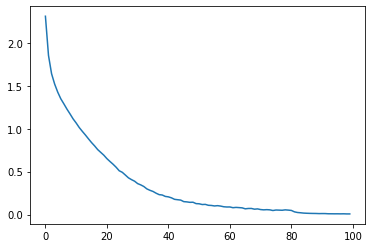

In [17]:
plt.plot(losses_old)

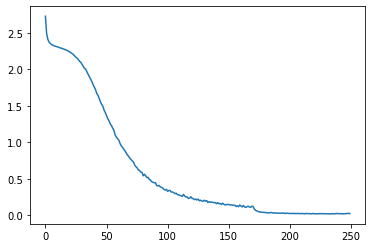

In [18]:
plt.plot(losses)

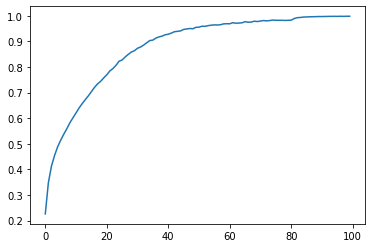

In [19]:
plt.plot(accs_old)

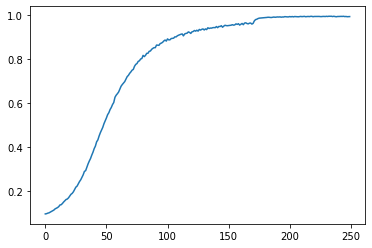

In [20]:
plt.plot(accs)